<a href="https://colab.research.google.com/github/Octaxx/DLI-Assignment/blob/main/Compile_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# === Step 1: Load DatasetCleaning.ipynb from GitHub ===
import requests, nbformat
from IPython import get_ipython


url = "https://raw.githubusercontent.com/Octaxx/DLI-Assignment/refs/heads/main/DatasetCleaning.ipynb"
response = requests.get(url)
notebook = nbformat.reads(response.text, as_version=4)
ipython = get_ipython()

print("⚙️ Running cells from DatasetCleaning.ipynb...\n")
for i, cell in enumerate(notebook.cells):
    if cell.cell_type == 'code':
        try:
            print(f"▶️ Executing cell {i+1}...")
            ipython.run_cell(cell.source)
        except Exception as e:
            print(f"❌ Error in cell {i+1}: {e}")
print("\n✅ All notebook cells executed.")



⚙️ Running cells from DatasetCleaning.ipynb...

▶️ Executing cell 2...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
▶️ Executing cell 3...
📊 BEFORE BALANCING
--------------------------------------------------
Total rows before balancing: 18634
Class balance before balancing:
Email Type
Safe Email        11322
Phishing Email     7312
Name: count, dtype: int64


,Email Text,Email Type,Label
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,0
1,the other side of * galicismos * * galicismo *...,Safe Email,0
2,re : equistar deal tickets are you still avail...,Safe Email,0
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,1
4,software at incredibly low prices ( 86 % lower...,Phishing Email,1
5,global risk management operations sally congra...,Safe Email,0
6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",Safe Email,0
7,"entourage , stockmogul newsletter ralph velez ...",Phishing Email,1
8,"we owe you lots of money dear applicant , afte...",Phishing Email,1
9,re : coastal deal - with exxon participation u...,Safe Email,0


▶️ Executing cell 4...

📊 AFTER BALANCING (Oversampling)
--------------------------------------------------
Total rows after balancing: 22644
Class balance after balancing:
Email Type
Phishing Email    11322
Safe Email        11322
Name: count, dtype: int64
▶️ Executing cell 5...

🧾 SAMPLE OF CLEANED & BALANCED DATAFRAME
Total Rows        : 22644
Phishing Emails   : 11322
Safe Emails       : 11322

🧪 Cleaned & Balanced DataFrame (First 5 Rows):


,Email Text,Email Type,Label
0,INVESTMENT SCHOLARS CLUB- bringing you the lat...,Phishing Email,1
1,semantics : il dominio tempo-aspettuale il dom...,Safe Email,0
2,mature mom and her young horny lover ! . . woo...,Phishing Email,1
3,do you own a car ; starting december 7 th ford...,Phishing Email,1
4,rescue you from highprice medicaments and badp...,Phishing Email,1



🎯 Phishing Emails (First 5):


,Email Text,Email Type,Label
0,INVESTMENT SCHOLARS CLUB- bringing you the lat...,Phishing Email,1
2,mature mom and her young horny lover ! . . woo...,Phishing Email,1
3,do you own a car ; starting december 7 th ford...,Phishing Email,1
4,rescue you from highprice medicaments and badp...,Phishing Email,1
11,New Web Technology\nUNLIMITED WEB CONFERENCING...,Phishing Email,1



✅ Safe Emails (First 5):


,Email Text,Email Type,Label
1,semantics : il dominio tempo-aspettuale il dom...,Safe Email,0
5,http://www.bbc.co.uk/radio1/alt/nireland/ni_te...,Safe Email,0
6,Hi Damian.SuSe has a Sparc version I previousl...,Safe Email,0
7,"hpl nom for may 25 , 2001 ( see attached file ...",Safe Email,0
8,iatl 14 : final cfp the 14th annual meeting - ...,Safe Email,0


▶️ Executing cell 6...

🧠 Sample Extracted Features (First 5):


,Email Preview,char_count,word_count,exclamation_count,uppercase_ratio,has_link,has_login_word,has_html
0,INVESTMENT SCHOLARS CLUB- bringing you the lat...,3893,586,2,0.034,0,1,0
1,semantics : il dominio tempo-aspettuale il dom...,904,154,0,0.000,0,0,0
2,mature mom and her young horny lover ! . . woo...,664,141,1,0.000,0,0,0
3,do you own a car ; starting december 7 th ford...,792,170,0,0.000,0,0,0
4,rescue you from highprice medicaments and badp...,796,163,0,0.000,0,0,0



✅ Final Columns:
['Email Text', 'Email Type', 'Label', 'Email Preview', 'char_count', 'word_count', 'exclamation_count', 'uppercase_ratio', 'has_link', 'has_login_word', 'has_html']

✅ All notebook cells executed.


In [13]:
# === Step 2: Set Number of Epochs and Training Runs ===
try:
    n_epochs = int(input("Enter number of epochs: "))
except:
    n_epochs = 5
    print("⚠️ Invalid input. Defaulting epochs to 5.")

try:
    num_runs = int(input("Enter number of ensemble training runs: "))
except:
    num_runs = 3
    print("⚠️ Invalid input. Defaulting ensemble runs to 3.")

Enter number of epochs: 2
Enter number of ensemble training runs: 5


### **BELOW IS GAVIN's MODEL:**

In [14]:
# === Step 3: Feature Engineering for Classical Models ===
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time
from scipy.sparse import hstack, csr_matrix
import pandas as pd

df_G = df_balanced.copy()


# Feature extraction from text
df_G['url_count'] = df_G['Email Text'].str.count(r'http[s]?://')
df_G['num_dots'] = df_G['Email Text'].str.count(r'\.')
df_G['has_attachment_word'] = df_G['Email Text'].str.contains(r'attachment|invoice|pdf', case=False).astype(int)
df_G['has_suspicious_word'] = df_G['Email Text'].str.contains(r'verify|account|confirm|login', case=False).astype(int)
df_G['avg_word_length'] = df_G['char_count'] / (df_G['word_count'] + 1)
df_G['special_char_count'] = df_G['Email Text'].str.count(r'[#$%^&*()]')
df_G['has_spam_phrase'] = df_G['Email Text'].str.contains(
    r'congratulations|you have won|limited time|click below', case=False
).astype(int)

tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_tfidf_G = tfidf.fit_transform(df_G['Email Text'])

stat_features = df_G[[
    'char_count', 'word_count', 'exclamation_count', 'uppercase_ratio',
    'has_link', 'has_login_word', 'has_html', 'url_count', 'num_dots',
    'has_attachment_word', 'has_suspicious_word', 'avg_word_length',
    'special_char_count', 'has_spam_phrase'
]]
stat_scaled = MinMaxScaler().fit_transform(stat_features)

def extract_cues(text):
    text = text.lower()
    return pd.Series({
        'has_urgent': int(any(w in text for w in ['urgent', 'immediate', 'now'])),
        'has_threat': int(any(w in text for w in ['suspend', 'locked', 'compromised'])),
        'has_generic': int(any(w in text for w in ['dear user', 'dear customer', 'valued customer']))
    })

cue_features = df_G['Email Text'].apply(extract_cues)
cue_scaled = MinMaxScaler().fit_transform(cue_features)

X_combined = hstack([X_tfidf_G, csr_matrix(stat_scaled), csr_matrix(cue_scaled)])
y = df_G['Label']

In [15]:
# === Step 4: LSTM Training ===
print("\n\U0001f9e0 Starting LSTM Training...")

max_words = 5000
max_len = 100
embedding_dim = 64

tokenizer_G = Tokenizer(num_words=max_words)
tokenizer_G.fit_on_texts(df_G['Email Text'])
sequences_G = tokenizer_G.texts_to_sequences(df_G['Email Text'])
X_seq_G = pad_sequences(sequences_G, maxlen=max_len)
y_seq_G = df_G['Label'].values

X_train_seq_G, X_test_seq_G, y_train_seq_G, y_test_seq_G = train_test_split(X_seq_G, y_seq_G, test_size=0.2, stratify=y_seq_G)

input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim)(input_layer)
lstm_layer = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)
output_layer = Dense(1, activation='sigmoid')(lstm_layer)

model_LSTM = Model(inputs=input_layer, outputs=output_layer)
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_G = model_LSTM.fit(X_train_seq_G, y_train_seq_G, epochs=n_epochs, batch_size=16,
                    validation_data=(X_test_seq_G, y_test_seq_G), verbose=1)

loss, acc_G = model_LSTM.evaluate(X_test_seq_G, y_test_seq_G, verbose=0)
print(f"\n✅ LSTM Accuracy after {n_epochs} epochs: {acc_G:.4f}")

# === Step 5: Hybrid Model Training (LSTM as Feature Extractor + Decision Tree + Random Forest) ===
print("\n🤖 Running Hybrid LSTM + Tree Models Training...\n")
all_conf_matrices = []

feature_extractor = Model(inputs=model_LSTM.input, outputs=lstm_layer)
X_lstm_features = feature_extractor.predict(X_seq_G)
y_lstm_labels = y_seq_G

results_G = []

for run in range(num_runs):
    print(f"\n📦 Hybrid Training Run {run + 1}/{num_runs}")
    start = time.time()

    X_train_G, X_test_G, y_train_G, y_test_G = train_test_split(
        X_lstm_features, y_lstm_labels, test_size=0.2, random_state=run, stratify=y_lstm_labels
    )

    clf_dt = DecisionTreeClassifier(max_depth=10, random_state=42)
    clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

    ensemble_G = VotingClassifier(estimators=[
        ('dt', clf_dt),
        ('rf', clf_rf)
    ], voting='soft')

    ensemble_G.fit(X_train_G, y_train_G)
    y_pred_G = ensemble_G.predict(X_test_G)
    y_proba_G = ensemble_G.predict_proba(X_test_G)[:, 1]

    acc_G = accuracy_score(y_test_G, y_pred_G)
    prec_G = precision_score(y_test_G, y_pred_G)
    rec_G = recall_score(y_test_G, y_pred_G)
    f1_G = f1_score(y_test_G, y_pred_G)
    roc_G = roc_auc_score(y_test_G, y_proba_G)
    elapsed = time.time() - start

    print(f"✅ Accuracy: {acc_G:.4f}, Precision: {prec_G:.4f}, Recall: {rec_G:.4f}, F1: {f1_G:.4f}, ROC AUC: {roc_G:.4f}, Time: {elapsed:.2f}s")

    results_G.append({
        'Run': run + 1, 'Accuracy': acc_G, 'Precision': prec_G,
        'Recall': rec_G, 'F1': f1_G, 'ROC_AUC': roc_G, 'Time': elapsed
    })

    cm = confusion_matrix(y_test_G, y_pred_G)
    all_conf_matrices.append(cm)

summary_df = pd.DataFrame(results_G)
from IPython.display import display

display(summary_df)

print("\n📊 Averages:")
print(summary_df.mean(numeric_only=True).round(4))



🧠 Starting LSTM Training...
Epoch 1/2
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 150s 125ms/step - accuracy: 0.8598 - loss: 0.3205 - val_accuracy: 0.9563 - val_loss: 0.1240
Epoch 2/2
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 194s 119ms/step - accuracy: 0.9684 - loss: 0.0919 - val_accuracy: 0.9739 - val_loss: 0.0751

✅ LSTM Accuracy after 2 epochs: 0.9739

🤖 Running Hybrid LSTM + Tree Models Training...

708/708 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step

📦 Hybrid Training Run 1/5
✅ Accuracy: 0.9815, Precision: 0.9682, Recall: 0.9956, F1: 0.9817, ROC AUC: 0.9982, Time: 15.44s

📦 Hybrid Training Run 2/5
✅ Accuracy: 0.9801, Precision: 0.9710, Recall: 0.9898, F1: 0.9803, ROC AUC: 0.9971, Time: 15.65s

📦 Hybrid Training Run 3/5
✅ Accuracy: 0.9812, Precision: 0.9694, Recall: 0.9938, F1: 0.9815, ROC AUC: 0.9978, Time: 15.65s

📦 Hybrid Training Run 4/5
✅ Accuracy: 0.9799, Precision: 0.9697, Recall: 0.9907, F1: 0.9801, ROC AUC: 0.9967, Time: 15.88s

📦 Hybrid Training Run 5/5
✅ Accuracy: 0.9828, Precision: 0.9715, Recall: 0.

,Run,Accuracy,Precision,Recall,F1,ROC_AUC,Time
0,1,0.981453,0.968213,0.995583,0.981707,0.998173,15.443837
1,2,0.980128,0.970983,0.989845,0.980324,0.997129,15.649906
2,3,0.981232,0.969410,0.993816,0.981461,0.997782,15.646077
3,4,0.979907,0.969736,0.990724,0.980118,0.996739,15.881233
4,5,0.982778,0.971527,0.994700,0.982977,0.997594,15.233505



📊 Averages:
Run           3.0000
Accuracy      0.9811
Precision     0.9700
Recall        0.9929
F1            0.9813
ROC_AUC       0.9975
Time         15.5709
dtype: float64


### **BELOW IS KAI FUNG's MODEL**:

In [16]:
import time
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

In [17]:
custom_features = ['char_count', 'word_count', 'exclamation_count',
                   'uppercase_ratio', 'has_link', 'has_login_word', 'has_html']

text_transformer = TfidfVectorizer(stop_words='english', max_features=7000, ngram_range=(1, 2), min_df=2)
column_transformer = ColumnTransformer([
    ('text', text_transformer, 'Email Text'),
    ('custom', 'passthrough', custom_features)
])

In [18]:
def create_mlp_model():
    mlp_model = Sequential([
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    mlp_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return mlp_model


In [19]:
#num_runs = int(input("Enter number of runs for evaluation (e.g., 10): "))
kf_results = []

In [20]:
from sklearn.ensemble import VotingClassifier

for run in range(num_runs):
    print(f"\n📦 Hybrid Training Run {run+1}/{num_runs}")

    # Prepare data
    kf_X = df_balanced[['Email Text'] + custom_features]
    kf_y = df_balanced['Label'].values
    kf_X_train, kf_X_test, kf_y_train, kf_y_test = train_test_split(kf_X, kf_y, test_size=0.2, stratify=kf_y, random_state=run)

    # MLP input
    kf_X_train_transformed = column_transformer.fit_transform(kf_X_train)
    kf_X_test_transformed = column_transformer.transform(kf_X_test)

    # === Train MLP ===
    mlp_model = create_mlp_model()
    kf_history = mlp_model.fit(kf_X_train_transformed, kf_y_train,
                        validation_split=0.1,
                        epochs=n_epochs,
                        batch_size=32,
                        verbose=1)

    # === Get MLP Probabilities ===
    train_probs = mlp_model.predict(kf_X_train_transformed).flatten().reshape(-1, 1)
    test_probs = mlp_model.predict(kf_X_test_transformed).flatten().reshape(-1, 1)

    # === Stack MLP output with original features ===
    kf_X_train_stack = np.hstack([train_probs, kf_X_train[custom_features].values])
    kf_X_test_stack = np.hstack([test_probs, kf_X_test[custom_features].values])

    scaler = MinMaxScaler()
    kf_X_train_stack = scaler.fit_transform(kf_X_train_stack)
    kf_X_test_stack = scaler.transform(kf_X_test_stack)

    # === Train Base Models ===
    clf_nb = MultinomialNB()
    clf_svm = CalibratedClassifierCV(estimator=LinearSVC(dual='auto'), cv=3)

    # === Voting Ensemble (only NB + SVM) ===
    kf_ensemble = VotingClassifier(estimators=[
        ('nb', clf_nb),
        ('svm', clf_svm)
    ], voting='soft')

    # Fit the ensemble
    kf_ensemble.fit(kf_X_train_stack, kf_y_train)

    # Predict
    kf_y_pred = kf_ensemble.predict(kf_X_test_stack)
    kf_y_proba = kf_ensemble.predict_proba(kf_X_test_stack)[:, 1]

    # Evaluate
    kf_acc = accuracy_score(kf_y_test, kf_y_pred)
    kf_prec = precision_score(kf_y_test, kf_y_pred)
    kf_rec = recall_score(kf_y_test, kf_y_pred)
    kf_f1 = f1_score(kf_y_test, kf_y_pred)
    kf_roc = roc_auc_score(kf_y_test, kf_y_proba)

    print(f"\n✅ Voting Ensemble (NB + SVM) Results:")
    print(f"Accuracy: {kf_acc:.4f}  Precision: {kf_prec:.4f}  Recall: {kf_rec:.4f}  F1: {kf_f1:.4f}  ROC AUC: {kf_roc:.4f}")

    kf_results.append({
        'Model': 'Voting NB + SVM',
        'Accuracy': kf_acc,
        'Precision': kf_prec,
        'Recall': kf_rec,
        'F1': kf_f1,
        'ROC_AUC': kf_roc
    })



📦 Hybrid Training Run 1/5
Epoch 1/2
510/510 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6311 - loss: 1.1052 - val_accuracy: 0.6192 - val_loss: 1.3444
Epoch 2/2
510/510 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7801 - loss: 0.7197 - val_accuracy: 0.8880 - val_loss: 0.3486
567/567 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

✅ Voting Ensemble (NB + SVM) Results:
Accuracy: 0.9020  Precision: 0.9201  Recall: 0.8803  F1: 0.8998  ROC AUC: 0.9472

📦 Hybrid Training Run 2/5
Epoch 1/2
510/510 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6829 - loss: 1.0709 - val_accuracy: 0.5999 - val_loss: 0.6938
Epoch 2/2
510/510 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8095 - loss: 0.6198 - val_accuracy: 0.6198 - val_loss: 0.7628
567/567 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

✅ Voting Ensemble (NB + SVM) Results:
Accuracy: 0.6436  Precision: 0.6073  Recall: 0.8132  F1: 0.6954  ROC AUC: 0.7280

📦 Hybrid Training Run 3/5
E

In [21]:
kf_results_df = pd.DataFrame(kf_results)
summary = kf_results_df.mean(numeric_only=True).round(4)
print("\n📊 Average Results Across All Runs:\n")
print(summary)


📊 Average Results Across All Runs:

Accuracy     0.8136
Precision    0.8023
Recall       0.8641
F1           0.8288
ROC_AUC      0.8720
dtype: float64


### **BELOW IS WENG KIT's MODEL:**

In [22]:
!pip install scikeras
!pip install scikit-learn==1.4.2

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from scikeras.wrappers import KerasClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input

# TF-IDF for LR and KNN
tfidf_vectorizer_WK = TfidfVectorizer(max_features=10000)
X_tfidf_WK = tfidf_vectorizer_WK.fit_transform(df_balanced['Email Text']).toarray()
y = df_balanced['Label'].values

# CNN Tokenization
tokenizer = Tokenizer(num_words=15000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_balanced['Email Text'])
sequences = tokenizer.texts_to_sequences(df_balanced['Email Text'])
X_seq = pad_sequences(sequences, maxlen=200)

# Train-Test Split
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf_WK, y, test_size=0.2, random_state=42)
X_train_seq, X_test_seq, _, _ = train_test_split(X_seq, y, test_size=0.2, random_state=42)


In [24]:
# Logistic Regression in Keras
def create_lr_model():
    model = Sequential()
    model.add(Input(shape=(X_train_tfidf.shape[1],)))  # use Input instead of input_dim
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

lr_model = KerasClassifier(model=create_lr_model, epochs=n_epochs, batch_size=32, verbose=0)

# KNN (no epochs)
knn_model = KNeighborsClassifier(n_neighbors=5)

# CNN in Keras
def create_cnn_model():
    model = Sequential()
    model.add(Input(shape=(200,)))  # replace input_length=200
    model.add(Embedding(input_dim=15000, output_dim=128))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = KerasClassifier(model=create_cnn_model, epochs=n_epochs, batch_size=64, verbose=1)



In [25]:
# Fit each model separately
lr_model.fit(X_train_tfidf, y_train, validation_data=(X_test_tfidf, y_test), verbose=1)
knn_model.fit(X_train_tfidf, y_train)
cnn_model.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test), verbose=1)
history = cnn_model.history_


Epoch 1/2
567/567 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8973 - loss: 0.6282 - val_accuracy: 0.9678 - val_loss: 0.4712
Epoch 2/2
567/567 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9655 - loss: 0.4354 - val_accuracy: 0.9702 - val_loss: 0.3510
Epoch 1/2
284/284 ━━━━━━━━━━━━━━━━━━━━ 52s 174ms/step - accuracy: 0.8005 - loss: 0.4296 - val_accuracy: 0.9759 - val_loss: 0.0646
Epoch 2/2
284/284 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - accuracy: 0.9820 - loss: 0.0478 - val_accuracy: 0.9777 - val_loss: 0.0564


In [26]:
# Get predictions from each
lr_preds = lr_model.predict(X_test_tfidf)
knn_preds = knn_model.predict(X_test_tfidf)
cnn_preds = cnn_model.predict(X_test_seq)

# Combine predictions using majority voting
import numpy as np
combined_preds = np.round((lr_preds + knn_preds + cnn_preds) / 3).astype(int)

# Evaluate ensemble
ensemble_acc = accuracy_score(y_test, combined_preds)
print(f"📊 Ensemble Model Accuracy: {ensemble_acc:.4f}")


71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step
📊 Ensemble Model Accuracy: 0.9737


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

acc_wk = accuracy_score(y_test, combined_preds)
prec_wk = precision_score(y_test, combined_preds)
recall_wk = recall_score(y_test, combined_preds)
F1_wk = f1_score(y_test, combined_preds)
ROC_wk = roc_auc_score(y_test, (lr_preds + knn_preds + cnn_preds) / 3)

results = {
    'Accuracy': acc_wk,
    'Precision': prec_wk,
    'Recall': recall_wk,
    'F1': F1_wk,
    'ROC_AUC': ROC_wk
}

import pandas as pd
summary_df_wk = pd.DataFrame([results]).round(4)

print("\n📊 Ensemble Model Evaluation Metrics:\n")
print(summary_df_wk)



📊 Ensemble Model Evaluation Metrics:

   Accuracy  Precision  Recall      F1  ROC_AUC
0    0.9737     0.9516  0.9973  0.9739   0.9871


## **COMPARISON TABLE OF 3 METHODS: **

In [29]:
# === Gavin's Results ===
gavin_df = pd.DataFrame(results_G)
gavin_avg = gavin_df.mean(numeric_only=True).round(4)

# === Kai Fung's Results ===
kf_df = pd.DataFrame(kf_results)
kf_avg = kf_df.mean(numeric_only=True).round(4)

# === Weng Kit's Result (Single Run Dict Already as DataFrame) ===
wk_df = summary_df_wk  # already created as: pd.DataFrame([results]).round(4)
wk_avg = wk_df.mean(numeric_only=True).round(4)

# === Combine into Comparison Table ===
comparison_df = pd.DataFrame({
    'Gavin': gavin_avg,
    'Kai Fung': kf_avg,
    'Weng Kit': wk_avg
}).T  # Transpose to make model names as rows

# === Display Table ===
from IPython.display import display

print("\n📋 Model Performance Comparison Table:")
display(comparison_df)



📋 Model Performance Comparison Table:


,Accuracy,F1,Precision,ROC_AUC,Recall,Run,Time
Gavin,0.9811,0.9813,0.9700,0.9975,0.9929,3.0,15.5709
Kai Fung,0.8136,0.8288,0.8023,0.8720,0.8641,NaN,NaN
Weng Kit,0.9737,0.9739,0.9516,0.9871,0.9973,NaN,NaN


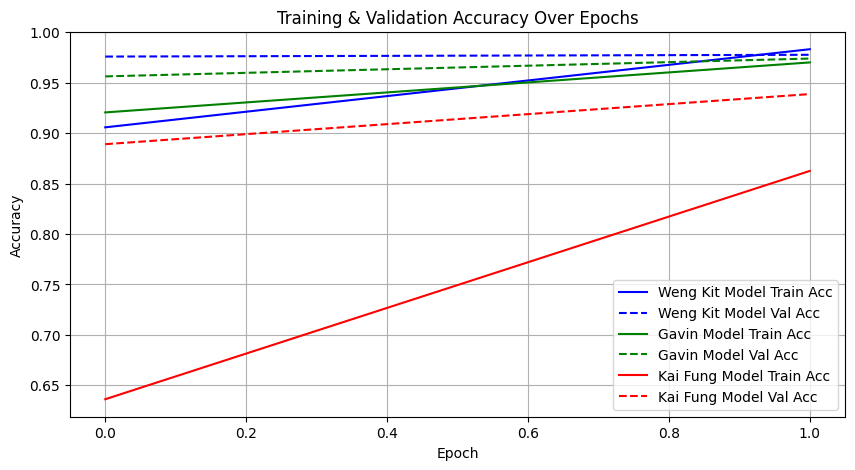

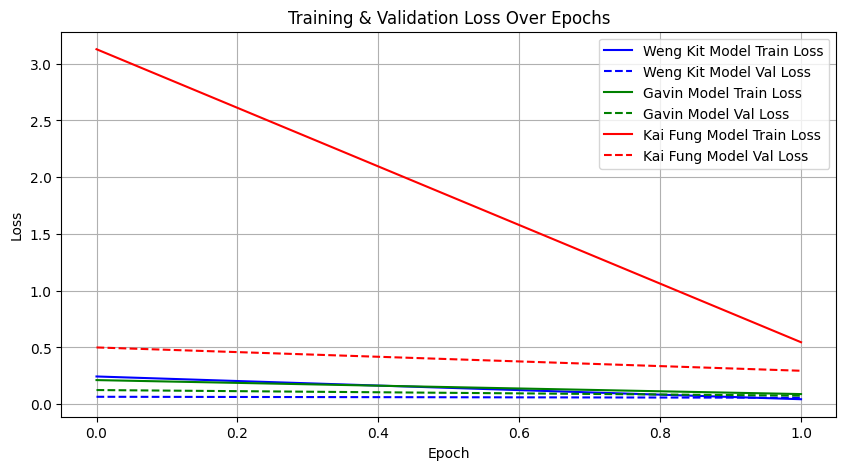

In [30]:
import matplotlib.pyplot as plt

# List of all histories
histories = [history, history_G, kf_history]
labels = ['Weng Kit Model', 'Gavin Model', 'Kai Fung Model']
colors = ['blue', 'green', 'red']

# Plot Accuracy
plt.figure(figsize=(10, 5))
for h, label, color in zip(histories, labels, colors):
    data = h.history if hasattr(h, 'history') else h  # ✅ Handle dict vs History object
    plt.plot(data['accuracy'], label=f'{label} Train Acc', linestyle='-', color=color)
    plt.plot(data['val_accuracy'], label=f'{label} Val Acc', linestyle='--', color=color)

plt.title('Training & Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
for h, label, color in zip(histories, labels, colors):
    data = h.history if hasattr(h, 'history') else h  # ✅ Handle dict vs History object
    plt.plot(data['loss'], label=f'{label} Train Loss', linestyle='-', color=color)
    plt.plot(data['val_loss'], label=f'{label} Val Loss', linestyle='--', color=color)

plt.title('Training & Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


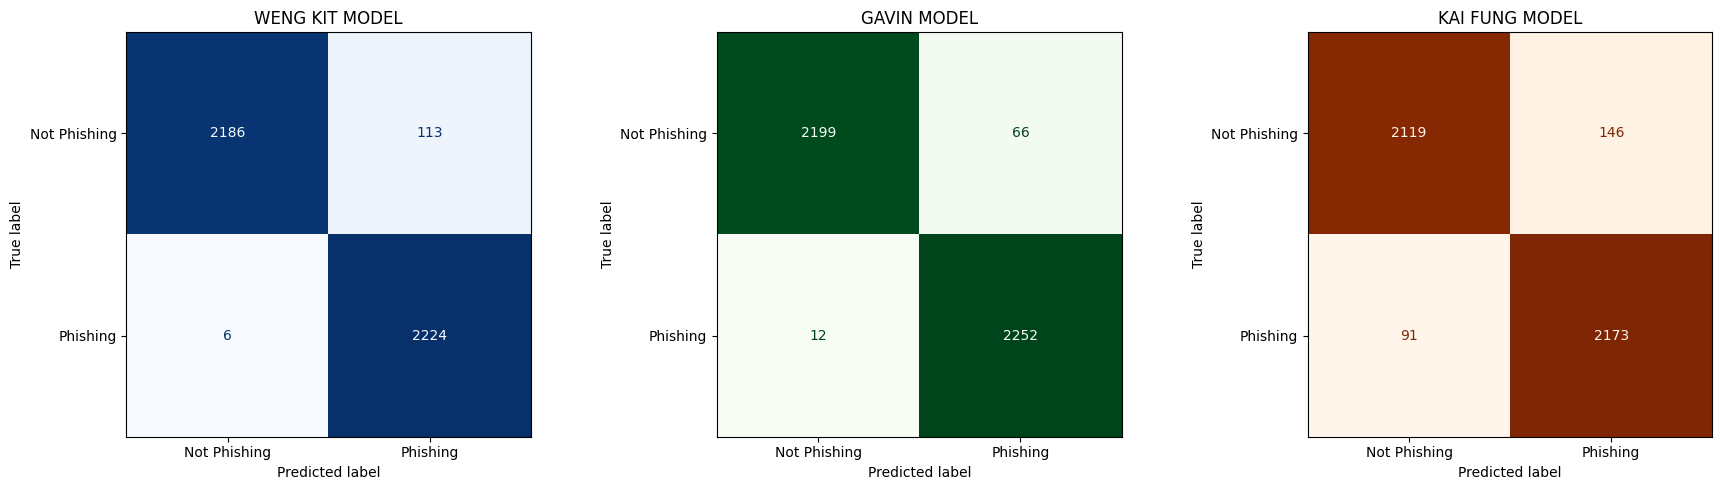

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# === Model 1 ===
cm1 = confusion_matrix(y_test, combined_preds)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['Not Phishing', 'Phishing'])
disp1.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('WENG KIT MODEL')

# === Model 2 ===
cm2 = confusion_matrix(y_test_G, y_pred_G)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['Not Phishing', 'Phishing'])
disp2.plot(ax=axes[1], cmap='Greens', colorbar=False)
axes[1].set_title('GAVIN MODEL')

# === Model 3 ===
cm3 = confusion_matrix(kf_y_test, kf_y_pred)
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=['Not Phishing', 'Phishing'])
disp3.plot(ax=axes[2], cmap='Oranges', colorbar=False)
axes[2].set_title('KAI FUNG MODEL')

# Show the full plot
plt.tight_layout()
plt.show()


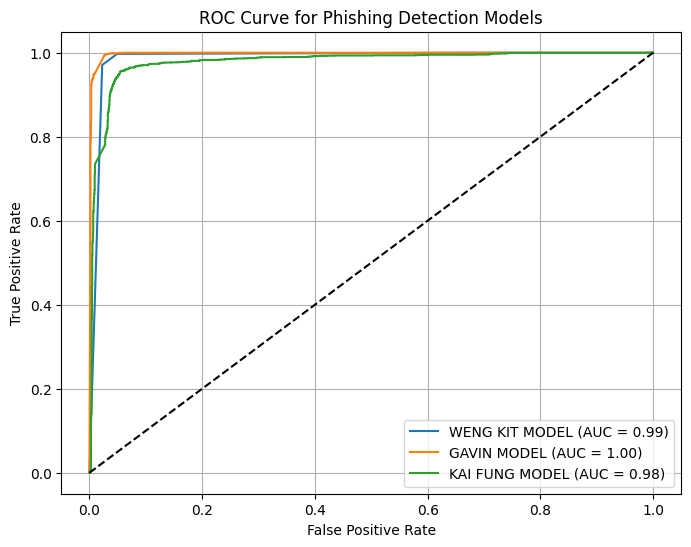

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# === Compute ROC curve and AUC ===
probs = (lr_preds + knn_preds + cnn_preds) / 3
fpr1, tpr1, _ = roc_curve(y_test, probs)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test_G, y_proba_G)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(kf_y_test, kf_y_proba)
roc_auc3 = auc(fpr3, tpr3)

# === Plot ===
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, label=f'WENG KIT MODEL (AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, label=f'GAVIN MODEL (AUC = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, label=f'KAI FUNG MODEL (AUC = {roc_auc3:.2f})')

# Diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Phishing Detection Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


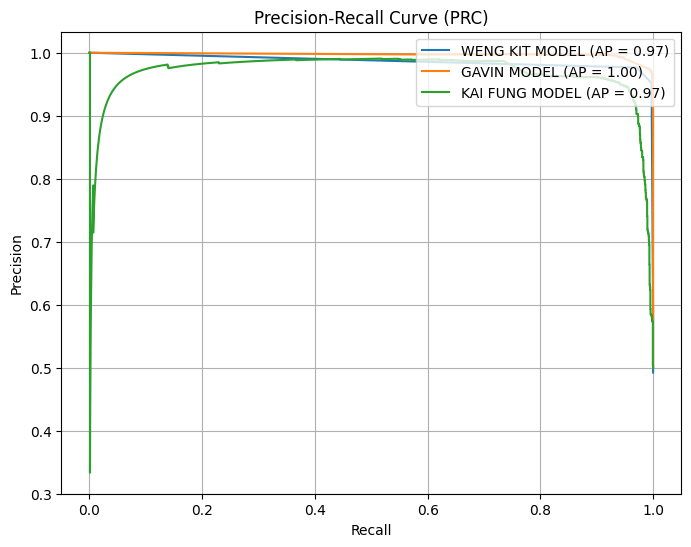

In [33]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# === Calculate PRC data ===
prec1, rec1, _ = precision_recall_curve(y_test, probs)
ap1 = average_precision_score(y_test, probs)

prec2, rec2, _ = precision_recall_curve(y_test_G, y_proba_G)
ap2 = average_precision_score(y_test_G, y_proba_G)

prec3, rec3, _ = precision_recall_curve(kf_y_test, kf_y_proba)
ap3 = average_precision_score(kf_y_test, kf_y_proba)

# === Plot PRC ===
plt.figure(figsize=(8, 6))
plt.plot(rec1, prec1, label=f'WENG KIT MODEL (AP = {ap1:.2f})')
plt.plot(rec2, prec2, label=f'GAVIN MODEL (AP = {ap2:.2f})')
plt.plot(rec3, prec3, label=f'KAI FUNG MODEL (AP = {ap3:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (PRC)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


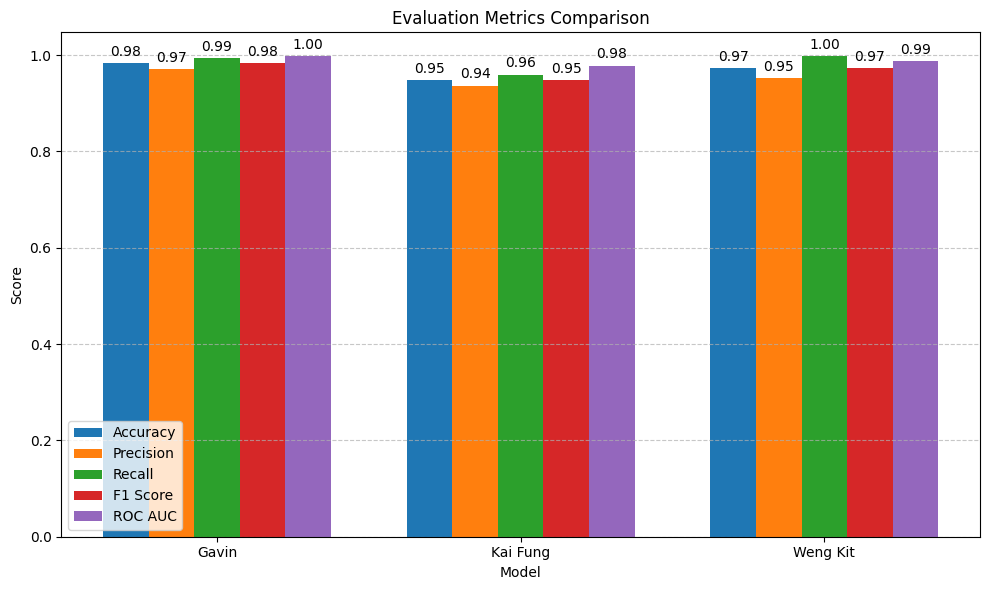

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Gavin', 'Kai Fung', 'Weng Kit']

# Replace with actual values
accuracy = [acc_G, kf_acc, acc_wk]
precision = [prec_G, kf_prec, prec_wk]
recall = [rec_G, kf_rec, recall_wk]
f1 = [f1_G, kf_f1, F1_wk]
roc = [roc_G, kf_roc, ROC_wk]  # If not available, you can remove this line & bar

# X-axis positioning
x = np.arange(len(models))
width = 0.15

fig, ax = plt.subplots(figsize=(10, 6))

# Bars
bars1 = ax.bar(x - 2*width, accuracy, width, label='Accuracy')
bars2 = ax.bar(x - width, precision, width, label='Precision')
bars3 = ax.bar(x, recall, width, label='Recall')
bars4 = ax.bar(x + width, f1, width, label='F1 Score')
bars5 = ax.bar(x + 2*width, roc, width, label='ROC AUC')

# Annotate each bar with value
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", ha='center', va='bottom')

# Add value labels
for bars in [bars1, bars2, bars3, bars4, bars5]:
    add_labels(bars)

# Labels and styling
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Evaluation Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

